# Trabajo Práctico Final
## Aprendizaje Profundo
## Ejercicio 2


##  Cohorte : 6Co2022

### Marcelo Chichiri

#### Enunciado :
Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.

#### Respuesta:
Se utilizó una red de tres capas ocultas, de 400, 200 y 100 neuronas con función de activación sigmoid para todas las capas excepto la de salida que es lineal.\
Se realizo el entrenamiento con 120 epocas.\
A pesar del tamaño de la red y de haber utilizado un learning rate de 0.0005 para lograr que la red se especialice tanto como para hacer overfeeting, eso no se logró. Se puede apreciar que la respuesta en validación es igual a la respuesta en training. Esto puede deberse a que el dataset aparentemente está generado con una función sin ruido.

A pesar de no haber logrado hacer overfeeting se aplicó regularización, aunque no sería necesario. Se puede apreciar que con regularización se llega a un error de 8.6e-10 frente al error de 2.4e-06 que se había llegado sin regularización. También se aprecia que sin regularización el error siempre es descendente, mientras que con regularización, antes de las 60 épocas, el error tiene grandes fluctuaciones. Después de las 60 épocas el error se estabiliza. 


In [1]:
# Importación de librerias necesarias
import pandas as pd 
import torch
import numpy as np
import matplotlib.pyplot as plt 

## Lectura y análisis de dataset 

In [2]:
df = pd.read_csv('dataset_1.csv')

In [3]:
len(df)

10000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   # X     10000 non-null  float64
 1   Y       10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


In [5]:
df.head()

,# X,Y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


## Split

In [6]:
 # ok
x=df.iloc[:,0].values 
y=df.iloc[:,1].values
 
largo = len(y)
x = x.squeeze().reshape(largo, 1)
y = y.squeeze().reshape(largo, 1)

In [7]:
len(x)

10000

In [8]:
n = len(x)
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.80 * n)]
valid_idx = idx[int(0.80 * n):]

In [9]:
n_train = len(train_idx)
n_valid = len(valid_idx)
print(f'datos para training : {n_train}, datos para validación : {n_valid}')

datos para training : 8000, datos para validación : 2000


In [10]:
print(type(y))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(8000, 1)
(8000, 1)
(2000, 1)
(2000, 1)


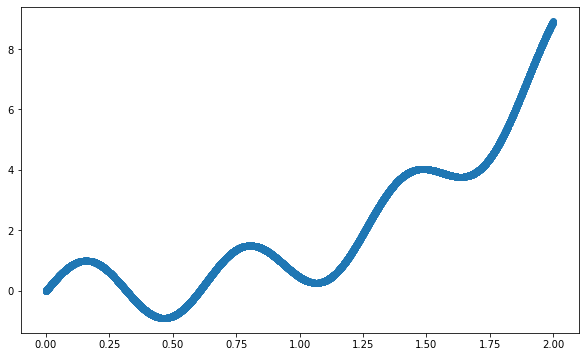

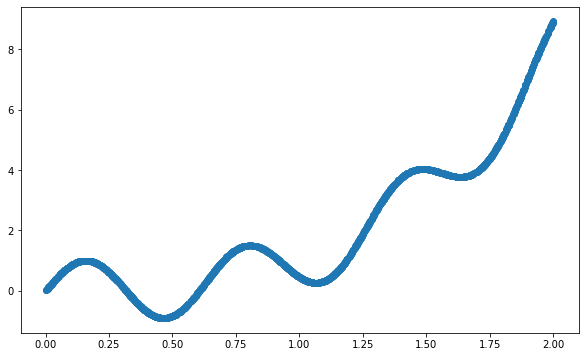

In [11]:

x_train = x[train_idx]
y_train = y[train_idx]
print(x_train.shape)
print(y_train.shape)

x_valid = x[valid_idx]
y_valid = y[valid_idx]
print(x_valid.shape)
print(y_valid.shape)

plt.figure(figsize=(10,6))
plt.scatter(x_train, y_train)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(x_valid, y_valid)
plt.show()

## NNet sin embeddings

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [13]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
train_ds = MyDataset(x_train, y_train) # dataset de entrenamiento

In [15]:
len(train_ds)

8000

In [16]:
valid_ds = MyDataset(x_valid, y_valid)

In [17]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [18]:
class NNet(torch.nn.Module):
    def __init__(self,D_in, H1, H2, H3, D_out):
        super(NNet,self).__init__()
        self.linear1 = torch.nn.Linear(D_in,H1)      
        self.linear2 = torch.nn.Linear(H1,H2)
        self.linear3 = torch.nn.Linear(H2,H3)
        self.linear4 = torch.nn.Linear(H3,D_out)
        
        
    def forward(self,x):
        x = self.linear1(x) 
        x = torch.sigmoid(x)  
        x = self.linear2(x)    
        x = torch.sigmoid(x)  
        x = self.linear3(x)  
        x = torch.sigmoid(x)  
        x = self.linear4(x)  

        return x
# Prueba de red
red = NNet(1, 10, 8, 2, 1) 
red

NNet(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=2, bias=True)
  (linear4): Linear(in_features=2, out_features=1, bias=True)
)

In [19]:
nnet = NNet(1, 400, 200, 100, 1) 

learning_rate = 0.0005
nnet

NNet(
  (linear1): Linear(in_features=1, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=1, bias=True)
)

In [20]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

In [21]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cpu'

In [22]:
# Entrenamiento y validación

nnet.to(device)

loss_by_epoch = []

val_loss_by_epoch = []

epocas = 120
for epoch in range(epocas):

    #########################################################################
    ####### TRAINING
    #########################################################################

    nnet.train(True)
    epoch_train_loss = 0

    for i_train, data_train in enumerate(train_dataloader):

        # obtener los datos del batch
        X_train_batch, y_train_batch = data_train

        X_train_batch = X_train_batch.to(device).float()
        y_train_batch = y_train_batch.to(device).float()

        # forward
        optimizer.zero_grad()

        y_train_batch_hat = nnet(X_train_batch)

        # calcula loss
        loss_train = loss_function(y_train_batch_hat, y_train_batch)
        
        # backpropagation
        loss_train.backward()

        # actualizar los parameteros
        optimizer.step()

        # acumula loss
        epoch_train_loss = epoch_train_loss + loss_train.item() 
        
    loss_by_epoch.append(epoch_train_loss  / len(train_ds))    


    #########################################################################
    ####### VALIDACION
    #########################################################################

    nnet.train(False)

    val_epoch_loss = 0

    for i_train, data_valid in enumerate(valid_dataloader):

        # obtener los datos del batch
        X_valid_batch, y_valid_batch = data_valid

        X_valid_batch = X_valid_batch.to(device).float()
        y_valid_batch = y_valid_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_valid_batch_hat = nnet(X_valid_batch)

        # calcula loss
        loss_val = loss_function(y_valid_batch_hat, y_valid_batch)

        # acumula loss
        val_epoch_loss = val_epoch_loss + loss_val.item() 
        
    val_loss_by_epoch.append(val_epoch_loss / len(valid_ds))

    #########################################################################
    ####### IMPRIME AVANCE DE ENTRENAMIENTO
    #########################################################################

    print(f"Epoch: {epoch} | Training loss: {epoch_train_loss / len(valid_ds)} | Valid loss: {val_epoch_loss / len(valid_ds)} ")

Epoch: 0 | Training loss: 0.4453244937956333 | Valid loss: 0.0330797405987978 
Epoch: 1 | Training loss: 0.09382069511711598 | Valid loss: 0.01917749361693859 
Epoch: 2 | Training loss: 0.075527782574296 | Valid loss: 0.018062862470746042 
Epoch: 3 | Training loss: 0.07159958447515964 | Valid loss: 0.017245164573192598 
Epoch: 4 | Training loss: 0.06966610279679299 | Valid loss: 0.01843311142921448 
Epoch: 5 | Training loss: 0.06757995286583901 | Valid loss: 0.016767197087407114 
Epoch: 6 | Training loss: 0.06528404073417186 | Valid loss: 0.016238881826400757 
Epoch: 7 | Training loss: 0.06396216210722923 | Valid loss: 0.015553331732749939 
Epoch: 8 | Training loss: 0.06137691251933575 | Valid loss: 0.015285721585154533 
Epoch: 9 | Training loss: 0.058821139723062514 | Valid loss: 0.015057910487055778 
Epoch: 10 | Training loss: 0.05637549917399883 | Valid loss: 0.014137521132826805 
Epoch: 11 | Training loss: 0.05452531591057777 | Valid loss: 0.013369558349251747 
Epoch: 12 | Training

Epoch: 96 | Training loss: 4.19646965440279e-05 | Valid loss: 2.5400988834007875e-06 
Epoch: 97 | Training loss: 4.180629216807574e-05 | Valid loss: 4.321959866501857e-05 
Epoch: 98 | Training loss: 3.529404642085865e-05 | Valid loss: 8.663261239416898e-05 
Epoch: 99 | Training loss: 0.00037025974271546146 | Valid loss: 3.796095315919956e-07 
Epoch: 100 | Training loss: 4.683641310521125e-06 | Valid loss: 3.731752269686694e-07 
Epoch: 101 | Training loss: 5.122929033859691e-06 | Valid loss: 5.088325297037955e-07 
Epoch: 102 | Training loss: 3.62347609416247e-06 | Valid loss: 8.927624630814535e-07 
Epoch: 103 | Training loss: 4.901235468764753e-06 | Valid loss: 1.4441215811530128e-05 
Epoch: 104 | Training loss: 2.2276327639701775e-05 | Valid loss: 7.014917391643394e-06 
Epoch: 105 | Training loss: 9.86353730868359e-05 | Valid loss: 1.0022514856245834e-05 
Epoch: 106 | Training loss: 7.847379014492617e-05 | Valid loss: 1.1979985793004743e-05 
Epoch: 107 | Training loss: 3.15860044393048

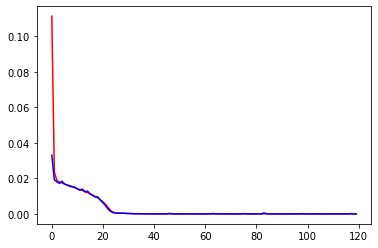

In [23]:
import matplotlib.pyplot as plt
fix, ax1 = plt.subplots(1,1)
ax1.plot(loss_by_epoch, color='red')
ax1.plot(val_loss_by_epoch, color='blue')

**** Se desplazan las curvas para poder apreciar que son todas iguales


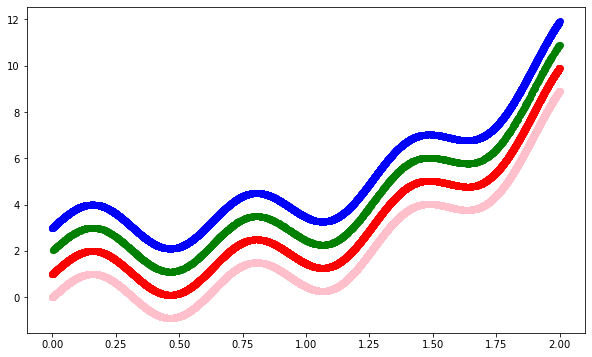

In [24]:
# testing

nnet.train(False)

train_dataloader = DataLoader(train_ds, batch_size=20000, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=20000, shuffle=True)

data_iter_va=iter(valid_dataloader)
data_iter_tr=iter(train_dataloader)

X_batch_tr, y_batch_tr = data_iter_tr.next()
X_batch_va, y_batch_va = data_iter_va.next()

X_batch_tr = X_batch_tr.to(device).float()
y_batch_tr = y_batch_tr.to(device).float()

X_batch_va = X_batch_va.to(device).float()
y_batch_va = y_batch_va.to(device).float()

y_batch_hat_tr = nnet(X_batch_tr)
y_batch_hat_va = nnet(X_batch_va)

#print(y_batch_hat, y_batch)
print('**** Se desplazan las curvas para poder apreciar que son todas iguales')
plt.figure(figsize=(10,6))
plt.scatter(X_batch_tr, y_batch_hat_tr.detach().numpy()+1, color='red')
plt.scatter(X_batch_va, y_batch_hat_va.detach().numpy()+2, color='green')
plt.scatter(x_train, y_train+3, color='blue')
plt.scatter(x, y, color='pink')
plt.show()

In [25]:
val_epoch_loss / len(valid_ds)

6.378259490702476e-07

## Modelo con regularizacion

In [26]:
# En la función de optimización se agrega el parámetro weight_decay para regularizar
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate, weight_decay=1e-6)


In [27]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cpu'

In [28]:
nnet.to(device)

loss_by_epoch = []

val_loss_by_epoch = []

epocas = 120
for epoch in range(epocas):

    #########################################################################
    ####### TRAINING
    #########################################################################

    nnet.train(True)
    epoch_train_loss = 0

    for i_train, data_train in enumerate(train_dataloader):

        # obtener los datos del batch
        X_train_batch, y_train_batch = data_train

        X_train_batch = X_train_batch.to(device).float()
        y_train_batch = y_train_batch.to(device).float()

        # forward
        optimizer.zero_grad()

        y_train_batch_hat = nnet(X_train_batch)
        
        # calcula loss
        loss_train = loss_function(y_train_batch_hat, y_train_batch)

        # backpropagation
        optimizer.zero_grad()
        loss_train.backward()

        # actualizar los parameteros
        optimizer.step()

        # acumula loss
        epoch_train_loss = epoch_train_loss + loss_train.item() 
        
    loss_by_epoch.append(epoch_train_loss  / len(train_ds))    


    #########################################################################
    ####### VALIDACION
    #########################################################################

    nnet.train(False)

    val_epoch_loss = 0

    for i_train, data_valid in enumerate(valid_dataloader):

        # obtener los datos del batch
        X_valid_batch, y_valid_batch = data_valid

        X_valid_batch = X_valid_batch.to(device).float()
        y_valid_batch = y_valid_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_valid_batch_hat = nnet(X_valid_batch)
        
        # calcula loss
        loss_val = loss_function(y_valid_batch_hat, y_valid_batch)

        # acumula loss
        val_epoch_loss = val_epoch_loss + loss_val.item() 
        
    val_loss_by_epoch.append(val_epoch_loss / len(valid_ds))

    #########################################################################
    ####### IMPRIME AVANCE DE ENTRENAMIENTO
    #########################################################################

    print(f"Epoch: {epoch} | Training loss: {epoch_train_loss / n_train} | Valid loss: {val_epoch_loss / n_valid} AUC: ")

Epoch: 0 | Training loss: 2.5057231596292696e-09 | Valid loss: 1.9634276628494263e-05 AUC: 
Epoch: 1 | Training loss: 4.913202486932278e-06 | Valid loss: 1.3044989900663495e-06 AUC: 
Epoch: 2 | Training loss: 3.2675365218892694e-07 | Valid loss: 4.547209478914738e-06 AUC: 
Epoch: 3 | Training loss: 1.1295159347355367e-06 | Valid loss: 1.1453935876488685e-05 AUC: 
Epoch: 4 | Training loss: 2.8439234010875227e-06 | Valid loss: 7.913939654827118e-06 AUC: 
Epoch: 5 | Training loss: 1.9644268322736024e-06 | Valid loss: 1.8341667018830776e-06 AUC: 
Epoch: 6 | Training loss: 4.5438893721438943e-07 | Valid loss: 1.8773855117615312e-07 AUC: 
Epoch: 7 | Training loss: 4.789244485436939e-08 | Valid loss: 3.0036340467631817e-06 AUC: 
Epoch: 8 | Training loss: 7.535598124377429e-07 | Valid loss: 5.532898008823395e-06 AUC: 
Epoch: 9 | Training loss: 1.3864946085959672e-06 | Valid loss: 4.8454315401613715e-06 AUC: 
Epoch: 10 | Training loss: 1.2146412627771497e-06 | Valid loss: 2.154480665922165e-06 

Epoch: 91 | Training loss: 1.250284640263999e-09 | Valid loss: 4.267110398359364e-09 AUC: 
Epoch: 92 | Training loss: 1.0959936389554059e-09 | Valid loss: 3.6495835047389847e-09 AUC: 
Epoch: 93 | Training loss: 9.400031899531313e-10 | Valid loss: 3.921287316188682e-09 AUC: 
Epoch: 94 | Training loss: 9.964355740521569e-10 | Valid loss: 4.433876711118501e-09 AUC: 
Epoch: 95 | Training loss: 1.1112911124655512e-09 | Valid loss: 4.299825832276838e-09 AUC: 
Epoch: 96 | Training loss: 1.07088226286578e-09 | Valid loss: 3.7923809941275975e-09 AUC: 
Epoch: 97 | Training loss: 9.464490062782716e-10 | Valid loss: 3.68990731658414e-09 AUC: 
Epoch: 98 | Training loss: 9.3057502681404e-10 | Valid loss: 3.960629783250624e-09 AUC: 
Epoch: 99 | Training loss: 1.0105960654982483e-09 | Valid loss: 3.975587333115982e-09 AUC: 
Epoch: 100 | Training loss: 1.0233661669190041e-09 | Valid loss: 3.650992766779382e-09 AUC: 
Epoch: 101 | Training loss: 9.42881229093473e-10 | Valid loss: 3.518086941767251e-09 AU

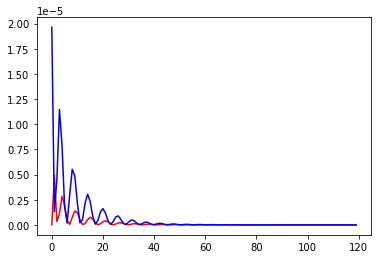

In [29]:
import matplotlib.pyplot as plt
fix, ax1 = plt.subplots(1,1)
ax1.plot(loss_by_epoch, color='red')
ax1.plot(val_loss_by_epoch, color='blue')

**** Se desplazan las curvas para poder apreciar que son todas iguales


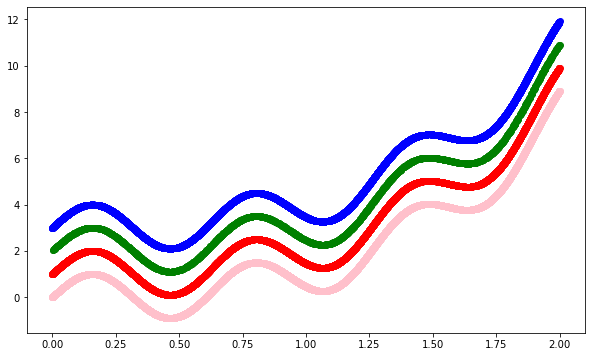

In [30]:
nnet.train(False)

train_dataloader = DataLoader(train_ds, batch_size=20000, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=20000, shuffle=True)

data_iter_va=iter(valid_dataloader)
data_iter_tr=iter(train_dataloader)

X_batch_tr, y_batch_tr = data_iter_tr.next()
X_batch_va, y_batch_va = data_iter_va.next()


X_batch_tr = X_batch_tr.to(device).float()
y_batch_tr = y_batch_tr.to(device).float()

X_batch_va = X_batch_va.to(device).float()
y_batch_va = y_batch_va.to(device).float()

y_batch_hat_tr = nnet(X_batch_tr)
y_batch_hat_va = nnet(X_batch_va)

#print(y_batch_hat, y_batch)
print('**** Se desplazan las curvas para poder apreciar que son todas iguales')
plt.figure(figsize=(10,6))
plt.scatter(X_batch_tr, y_batch_hat_tr.detach().numpy()+1, color='red')
plt.scatter(X_batch_va, y_batch_hat_va.detach().numpy()+2, color='green')
plt.scatter(x_train, y_train+3, color='blue')
plt.scatter(x, y, color='pink')
plt.show()